In [1]:
import emcee
import time
import math
import corner
import glob
import pandas as pd
import numpy as np
import scipy.optimize as op
import astropy.io.ascii as asci
from astropy.io import fits
from astropy.table import Table
from collections import Counter
from multiprocessing import Queue, Process, Pool
import time

%matplotlib notebook
import matplotlib.pyplot as plt


In [2]:
from multiprocessing import cpu_count
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

8 CPUs


## Read in the data

Force-fit photometry, as well as the "x" and "y" data needed to estimate the flux in individual epochs has been stored in individual fits files.

In [3]:
targets = glob.glob('ZTF18*/')

In [4]:
name1 = targets[0][:-1]
name2 = targets[1][:-1]
print ('%s: we should have a very good light curve for this one; \n%s: close to center of galaxy, bad subtraction'%(name1, name2))

ZTF18aaxsioa: we should have a very good light curve for this one; 
ZTF18aayjomr: close to center of galaxy, bad subtraction


In [5]:
forcepath1 = glob.glob(name1+'/force*.fits')[0]
xypath1 = glob.glob(name1+'/xy*.fits')[0]
forcepath2 = glob.glob(name2+'/force*.fits')[0]
xypath2 = glob.glob(name2+'/xy*.fits')[0]

In [6]:
forcetb1 = Table(fits.open(forcepath1)[1].data).to_pandas()
forcetb1 = forcetb1[forcetb1['rvalue']!=0]
tb1 = Table(fits.open(xypath1)[1].data).to_pandas()

forcetb2 = Table(fits.open(forcepath2)[1].data).to_pandas()
forcetb2 = forcetb2[forcetb2['rvalue']!=0]
tb2 = Table(fits.open(xypath2)[1].data).to_pandas()

## Define posterior calculation

We attempt two different models to measure the slope: a mixture model (see [Hogg, Bovy, and Lang 2010](https://arxiv.org/abs/1008.4686)) that treats the data as coming from a foreground population (the actual flux measured by the PSF) and a noisy high-variance background population. While, in principle, this is the most appropriate model to deal with bad pixels or columns in the subtraction image, in practice, during epochs when the SN (or other transient) is not clearly detected there isn't enough signal for the foreground linear signal to constrain the flux. By definition the slope = 0 when the source isn't detected, which is why the mixture model fails to converge. (TODO: try adjusting the prior so that most points must belong to the foreground population)

The second model is just a linear model $y = mx + b$, where we assume the uncertainties are underestimated by a constant factor $\sigma_0$. This yields a likelihood: 

$$ \ln \mathcal{L} = \sum_i \ln \left(\frac{1}{\sqrt{2\pi (\sigma_i^2 + \sigma_0^2)}}\right) - 
                               \frac{(y_i - (mx_i + b))^2}{2(\sigma_i^2 + \sigma_0^2)}$$
                               
For this likelihood we can marginalize over $b$ and $\sigma_0$ in order to estimate the slope, $m$ and it's uncertainty, from which the SN flux can be trivially estimated.

In [66]:
# likelihood function lnL
def mixture_lnlike(theta, x, y, sigma_y):
    m, b, p_b, lnv_b, y_b = theta
    model = m * x + b
    bad_noise = np.exp(lnv_b) + sigma_y*sigma_y
    ln_l = np.sum( np.log( (1 - p_b)/np.sqrt(2*np.pi*sigma_y*sigma_y)*np.exp(-1/2*((y - model)/sigma_y)**2) + 
                    (p_b)/np.sqrt(2*np.pi*(bad_noise))*np.exp(-1/2*(y - y_b)**2/(bad_noise))
                          )
                  )
    
    return ln_l

def systematic_lnlike(theta, x, y, sigma_y):
    m, b, lnsig_0 = theta
    model = m * x + b
    sig_0 = np.exp(lnsig_0)

    chi2_term = -1/2*np.sum((y - model)**2/(sigma_y**2 + sig_0**2))
    error_term = np.sum(np.log(1/np.sqrt(2*np.pi*(sigma_y**2 + sig_0**2))))
    ln_l = chi2_term + error_term

    return ln_l

# prior function
def mixture_lnprior(theta):
    m, b, p_b, lnv_b, y_b = theta
    if (-1e6 < m < 1e6 and -1e6 < b < 1e6 and 
        0 < p_b < 1.0 and 
        -20 < lnv_b < 20 and -1e6 < y_b < 1e6):
        return 0.0
    return -np.inf

nll = lambda *args: -systematic_lnlike(*args)

def systematic_lnprior(theta):
    m, b, lnsig_0 = theta
    if (-1e6 < m < 1e6 and -1e6 < b < 1e6 and 
        -50 < lnsig_0 < 50):
        return 0.0
    return -np.inf

# The full log-probability function is
def mixture_lnprob(theta, x, y, yerr):
    lp = mixture_lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + mixture_lnlike(theta, x, y, yerr)

def systematic_lnprob(theta, x, y, yerr):
    lp = systematic_lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + systematic_lnlike(theta, x, y, yerr)

### An example MCMC calculation

Below we show example results for a subtraction where a maximum-likelihood approach would produce unreasonable estimates of the flux.

In [42]:
nsteps = 5000
ndim, nwalkers = 3, 500
f_true = 1
nburn = 2500

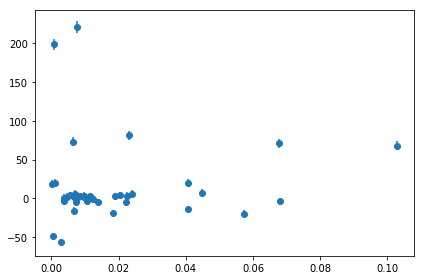

In [71]:
subtb = tb1[tb1['index']==45]
x = subtb['x'].values
y = subtb['y'].values
yerr = subtb['ey'].values

fig, ax = plt.subplots()
ax.errorbar(x, y, yerr, fmt='o')
fig.tight_layout()

In [72]:
result = op.minimize(nll, [2, 0, 2], 
                     method='Powell', args=(x, y, yerr))
ml_guess = result["x"]
print(ml_guess)

[147.91366593  13.55998479   3.97354165]


In [73]:
if ml_guess[-1] < -49:
    ml_guess[-1] = -35
ndim = len(ml_guess)
nwalkers = 250

pos = [ml_guess + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

# set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, systematic_lnprob, 
                                args=(x, y, yerr))

max_samples = 15000

index = 0
autocorr = np.empty(max_samples)
old_tau = np.inf
check_tau = 250
for sample in sampler.sample(pos, iterations=max_samples, progress=True):
    if sampler.iteration % check_tau:
        continue
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

  0%|          | 35/15000 [00:00<02:16, 109.94it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
 97%|█████████▋| 14500/15000 [02:30<00:05, 96.61it/s] 


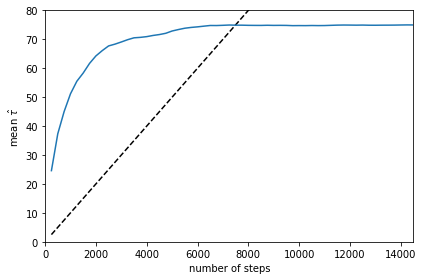

In [74]:
n = check_tau*np.arange(1, index+1)
mean_tau = autocorr[:index]
plt.figure()
plt.plot(n, n / 100.0, "--k")
plt.plot(n, mean_tau)
plt.xlim(0, n.max())
plt.ylim(0, mean_tau.max() + 0.1*(mean_tau.max() - mean_tau.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$")
plt.tight_layout()

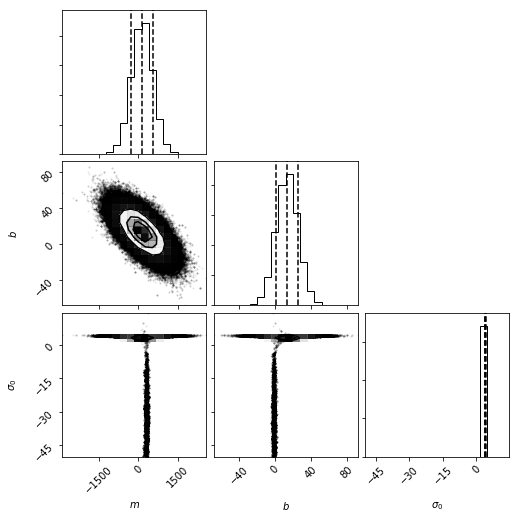

In [75]:
makeCorner(sampler, int(10*np.mean(tau)), paramsNames)

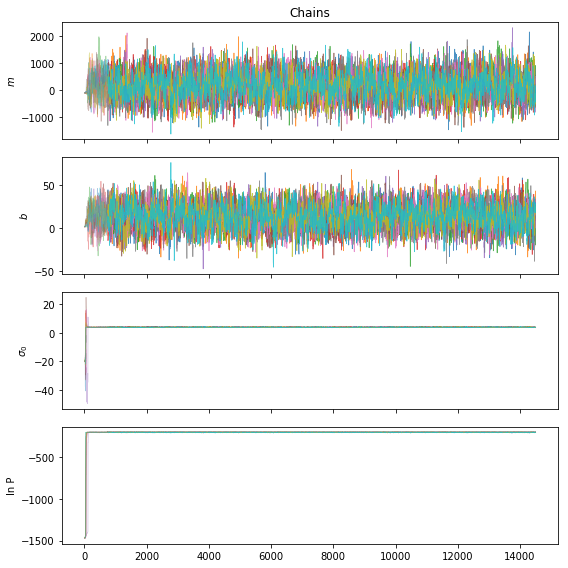

In [76]:
plotChains(sampler, int(10*np.mean(tau)), paramsNames, nplot=10)
plt.tight_layout()

## Script up parallel solution

Now that we have a method to identify the best fit slope, we would like to take advantage of the fact that this problem can be parallelized by fitting each epoch individually. 

In [77]:
def single_process(tb, i, output):
    print (i)
    subtb = tb[tb['index']==i]
    x = subtb['x'].values
    y = subtb['y'].values
    yerr = subtb['ey'].values
        
    # two parameters (np.log(f_true) = 0)
    result = op.minimize(nll, [0, 0, 2], 
                         method='Powell', args=(x, y, yerr))
    ml_guess = result["x"]

    if ml_guess[-1] < -49:
        ml_guess[-1] = -35
    ndim = len(ml_guess)
    nwalkers = 250
    
    # two parameters
    pos = [ml_guess + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

    # set up the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, systematic_lnprob, 
                                    args=(x, y, yerr))

    max_samples = 100000

    index = 0
    autocorr = np.empty(max_samples)
    old_tau = np.inf
    check_tau = 250
    for sample in sampler.sample(pos, iterations=max_samples, progress=False):
        if sampler.iteration % check_tau:
            continue
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau  
    
    samples = sampler.get_chain(discard=int(5*np.mean(tau)), flat=True)
    
    Fmcmc_low, Fmcmc_med, Fmcmc_high = np.percentile(samples[:,0], (15.87, 50, 84.13))
    amcmc_low, amcmc_med, amcmc_high = np.percentile(samples[:,1], (15.87, 50, 84.13))
    # lnf_low, lnf_med, lnf_high = np.percentile(samples.T[2], (15.87, 50, 84.13))
    result = np.array([i, # position argument
                       Fmcmc_med, (Fmcmc_high - Fmcmc_low)/2.,
                       amcmc_med, (amcmc_high - amcmc_low)/2.])
    output.put(result)

In [78]:
def pool_process(tb, i):
    print (i)
    subtb = tb[tb['index']==i]
    x = subtb['x'].values
    y = subtb['y'].values
    yerr = subtb['ey'].values
        
    # two parameters (np.log(f_true) = 0)
    result = op.minimize(nll, [0, 0, 2], 
                         method='Powell', args=(x, y, yerr))
    ml_guess = result["x"]

    if ml_guess[-1] < -49:
        ml_guess[-1] = -35
    ndim = len(ml_guess)
    nwalkers = 250
    
    # two parameters
    pos = [ml_guess + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

    # set up the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, systematic_lnprob, 
                                    args=(x, y, yerr))

    max_samples = 100000

    index = 0
    autocorr = np.empty(max_samples)
    old_tau = np.inf
    check_tau = 250
    for sample in sampler.sample(pos, iterations=max_samples, progress=False):
        if sampler.iteration % check_tau:
            continue
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau  
    
    samples = sampler.get_chain(discard=int(5*np.mean(tau)), flat=True)
    
    Fmcmc_low, Fmcmc_med, Fmcmc_high = np.percentile(samples[:,0], (15.87, 50, 84.13))
    amcmc_low, amcmc_med, amcmc_high = np.percentile(samples[:,1], (15.87, 50, 84.13))
    # lnf_low, lnf_med, lnf_high = np.percentile(samples.T[2], (15.87, 50, 84.13))
    result = np.array([i, # position argument
                       Fmcmc_med, (Fmcmc_high - Fmcmc_low)/2.,
                       amcmc_med, (amcmc_high - amcmc_low)/2.])
    return result

In [79]:
pool = Pool(processes=4)
tstart = time.time()
results = [pool.apply_async(pool_process, args=(tb2, i,)) for i in range(17)]
output = [p.get() for p in results]
tend = time.time()

print("Pool map took {:.4f} sec".format(tend-tstart))

0
1
2
3


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


4


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


5
6
7
8
9
10
11
12
13
14
15
16
Pool map took 400.6010 sec


In [80]:
tstart = time.time()
n2=17
ncpu = 4
nruns = math.ceil(n2/ncpu)
results = []
for j in range(math.ceil(n2/ncpu)):
#for j in range(2):
    if j==nruns-1:
        irange = np.arange(j*ncpu, n2)
    else:
        irange = np.arange(j*ncpu, (j+1)*ncpu)
        
    output = Queue()
    processes = [Process(target=single_process, args=(tb2, i, output)) for i in irange]
    # Run processes
    for p in processes:
        p.start()

    # Exit the completed processes
    for p in processes:
        p.join()
    
    temp = [output.get() for p in processes]
    results.append(temp)
    
    output.close()
tend = time.time()
print("Queue took {:.4f} sec".format(tend-tstart))

0
1
2
3


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


4
5
6
7


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encoun

8
9
10
11


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encoun

12
13
14
15


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


16


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


Queue took 522.1754 sec


In [50]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84], truths=[]):
    samples = sampler.get_chain(discard=nburn, flat=True)
    if len(truths) > 0:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, truths=truths)
    else:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, )
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames, nplot=nwalkers):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams+1,1, figsize = (8,2*(Nparams+1)), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = np.arange(sampler.get_chain().shape[0])

    selected_walkers = np.random.choice(range(sampler.get_chain().shape[1]), nplot, replace=False)
    for i,p in enumerate(paramsNames):
        for w in selected_walkers:
            burn = ax[i].plot(xplot[:nburn], sampler.get_chain()[:nburn,w,i], 
                              alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.get_chain(discard=nburn)[:,w,i], 
                       color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            if i==Nparams-1:
                ax[i+1].plot(xplot[:nburn], sampler.get_log_prob()[:nburn,w], 
                             color=burn[0].get_color(), alpha = 0.4, lw = 0.7, zorder = 1)
                ax[i+1].plot(xplot[nburn:], sampler.get_log_prob(discard=nburn)[:,w], 
                             color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
                ax[i+1].set_ylabel('ln P')
            
    return ax

paramsNames=['$m$', '$b$', '$\sigma_0$']